In [2]:
import scanpy as sc
import pandas as pd
import pickle
import time
import anndata
import sklearn.metrics
%matplotlib notebook
%pylab

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In [5]:
df = pd.read_table("matrix_mixology/sc_dropseq.count.csv.gz", compression="gzip", sep=",")
nomi=pd.read_csv('regressed_genes/nomi_geni.txt.gz', compression= 'gzip')
cell_cycle_genes = [x.strip() for x in open('regressed_genes/regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
ensg_s_genes =[nomi.loc[idx, "Gene stable ID"] for idx in nomi.index if nomi.loc[idx, "Gene name"] in s_genes]
ensg_g2m_genes =[nomi.loc[idx, "Gene stable ID"] for idx in nomi.index if nomi.loc[idx, "Gene name"] in g2m_genes]
adata = anndata.AnnData(df.T)#.values.T, obs=df.columns, var=df.index)
mito_genes = [nomi.loc[idx, "Gene stable ID"] for idx in nomi.index if nomi.loc[idx, "Gene name"].startswith("MT-") and nomi.loc[idx, "Gene stable ID"] in adata.var_names]
 
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1) 
adata.obs['n_counts'] = adata.X.sum(axis=1)
np.sum(adata[:, mito_genes].X, axis=1)                                            
                                            

adata = adata[adata.obs['percent_mito'] < 0.05, :]
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
adata.raw = adata
sc.tl.score_genes_cell_cycle(adata, s_genes=ensg_s_genes, g2m_genes=ensg_g2m_genes)

sc.pp.highly_variable_genes(adata, min_mean=0.05, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var['highly_variable']]
sc.pp.regress_out(adata, ['S_score', 'G2M_score','n_counts', 'percent_mito'])
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
adata.write('mi_dropseq/adata_base.h5ad')

Trying to set attribute `.obs` of view, making a copy.


Trying to set attribute `.obs` of view, making a copy.
... storing 'phase' as categorical


In [6]:
adata=sc.read('mi_dropseq/adata_base.h5ad')

In [7]:
nei=[5,10,20,50,100]
adatone=[]
for x in nei:
    adata=sc.read('mi_dropseq/adata_base.h5ad')
    sc.pp.neighbors(adata, n_neighbors=x, n_pcs=40)
    adatone.append(adata)
adatone[0].write('mi_dropseq/adata_5.h5ad')
adatone[1].write('mi_dropseq/adata_10.h5ad')
adatone[2].write('mi_dropseq/adata_20.h5ad')
adatone[3].write('mi_dropseq/adata_50.h5ad')
adatone[4].write('mi_dropseq/adata_100.h5ad')

In [8]:
adata5=sc.read('mi_dropseq/adata_5.h5ad')
adata10=sc.read('mi_dropseq/adata_10.h5ad')
adata20=sc.read('mi_dropseq/adata_20.h5ad')
adata50=sc.read('mi_dropseq/adata_50.h5ad')
adata100=sc.read('mi_dropseq/adata_100.h5ad')

In [3]:
sc.tl.umap(adata5)
sc.tl.umap(adata10) 
sc.tl.umap(adata20) 
sc.tl.umap(adata50)
sc.tl.umap(adata100) 

NameError: name 'adata5' is not defined

# 1) leiden in range
### 1.1) leiden unweighted

In [10]:
resolutions = np.arange(0, 1, 0.005)

In [11]:
leiden_clusters = pd.DataFrame(index=adata5.obs_names, columns=resolutions)
for r in resolutions:
    sc.tl.leiden(adata5, resolution=r, use_weights=False)
    leiden_clusters.loc[:, r] = adata5.obs.leiden
leiden_clusters.to_csv('mi_dropseq/dropseq_leiden_clusters_5_unweighted.csv')

In [12]:
leiden_clusters = pd.DataFrame(index=adata10.obs_names, columns=resolutions)
for r in resolutions:
    sc.tl.leiden(adata10, resolution=r, use_weights=False)
    leiden_clusters.loc[:, r] = adata10.obs.leiden
leiden_clusters.to_csv('mi_dropseq/dropseq_leiden_clusters_10_unweighted.csv')

In [13]:
leiden_clusters = pd.DataFrame(index=adata20.obs_names, columns=resolutions)
for r in resolutions:
    sc.tl.leiden(adata20, resolution=r, use_weights=False)
    leiden_clusters.loc[:, r] = adata20.obs.leiden
leiden_clusters.to_csv('mi_dropseq/dropseq_leiden_clusters_20_unweighted.csv')

In [14]:
leiden_clusters = pd.DataFrame(index=adata50.obs_names, columns=resolutions)
for r in resolutions:
    sc.tl.leiden(adata50, resolution=r, use_weights=False)
    leiden_clusters.loc[:, r] = adata50.obs.leiden
leiden_clusters.to_csv('mi_dropseq/dropseq_leiden_clusters_50_unweighted.csv')

In [15]:
leiden_clusters = pd.DataFrame(index=adata100.obs_names, columns=resolutions)
for r in resolutions:
    sc.tl.leiden(adata100, resolution=r, use_weights=False)
    leiden_clusters.loc[:, r] = adata100.obs.leiden
leiden_clusters.to_csv('mi_dropseq/dropseq_leiden_clusters_100_unweighted.csv')

In [4]:
unw_leiden_clusters5=pd.read_csv('mi_dropseq/dropseq_leiden_clusters_5_unweighted.csv')
unw_leiden_clusters10=pd.read_csv('mi_dropseq/dropseq_leiden_clusters_10_unweighted.csv')
unw_leiden_clusters20=pd.read_csv('mi_dropseq/dropseq_leiden_clusters_20_unweighted.csv')
unw_leiden_clusters50=pd.read_csv('mi_dropseq/dropseq_leiden_clusters_50_unweighted.csv')
unw_leiden_clusters100=pd.read_csv('mi_dropseq/dropseq_leiden_clusters_100_unweighted.csv')

### 1.2) leiden weighted

In [30]:
adata5=sc.read('mi_dropseq/adata_5.h5ad')
adata10=sc.read('mi_dropseq/adata_10.h5ad')
adata20=sc.read('mi_dropseq/adata_20.h5ad')
adata50=sc.read('mi_dropseq/adata_50.h5ad')
adata100=sc.read('mi_dropseq/adata_100.h5ad')

In [31]:
leiden_clusters = pd.DataFrame(index=adata5.obs_names, columns=resolutions)
for r in resolutions:
    sc.tl.leiden(adata5, resolution=r, use_weights=True)
    leiden_clusters.loc[:, r] = adata5.obs.leiden
leiden_clusters.to_csv('mi_dropseq/dropseq_leiden_clusters_5_weighted.csv')

In [32]:
leiden_clusters = pd.DataFrame(index=adata10.obs_names, columns=resolutions)
for r in resolutions:
    sc.tl.leiden(adata10, resolution=r, use_weights=True)
    leiden_clusters.loc[:, r] = adata10.obs.leiden
leiden_clusters.to_csv('mi_dropseq/dropseq_leiden_clusters_10_weighted.csv')

In [33]:
leiden_clusters = pd.DataFrame(index=adata20.obs_names, columns=resolutions)
for r in resolutions:
    sc.tl.leiden(adata20, resolution=r, use_weights=True)
    leiden_clusters.loc[:, r] = adata20.obs.leiden
leiden_clusters.to_csv('mi_dropseq/dropseq_leiden_clusters_20_weighted.csv')

In [34]:
leiden_clusters = pd.DataFrame(index=adata50.obs_names, columns=resolutions)
for r in resolutions:
    sc.tl.leiden(adata50, resolution=r, use_weights=True)
    leiden_clusters.loc[:, r] = adata50.obs.leiden
leiden_clusters.to_csv('mi_dropseq/dropseq_leiden_clusters_50_weighted.csv')

In [35]:
leiden_clusters = pd.DataFrame(index=adata100.obs_names, columns=resolutions)
for r in resolutions:
    sc.tl.leiden(adata100, resolution=r, use_weights=True)
    leiden_clusters.loc[:, r] = adata100.obs.leiden
leiden_clusters.to_csv('mi_dropseq/dropseq_leiden_clusters_100_weighted.csv')

In [5]:
w_leiden_clusters5=pd.read_csv('mi_dropseq/dropseq_leiden_clusters_5_weighted.csv')
w_leiden_clusters10=pd.read_csv('mi_dropseq/dropseq_leiden_clusters_10_weighted.csv')
w_leiden_clusters20=pd.read_csv('mi_dropseq/dropseq_leiden_clusters_20_weighted.csv')
w_leiden_clusters50=pd.read_csv('mi_dropseq/dropseq_leiden_clusters_50_weighted.csv')
w_leiden_clusters100=pd.read_csv('mi_dropseq/dropseq_leiden_clusters_100_weighted.csv')

# 2) nsbm
### 2.1) nsbm unweighted

In [24]:
adata5=sc.read('mi_dropseq/adata_5.h5ad')
adata10=sc.read('mi_dropseq/adata_10.h5ad')
adata20=sc.read('mi_dropseq/adata_20.h5ad')
adata50=sc.read('mi_dropseq/adata_50.h5ad')
adata100=sc.read('mi_dropseq/adata_100.h5ad')

In [25]:
a=time.time()
sc.tl.nsbm(adata5, collect_marginals=False)
b=time.time()
sc.tl.nsbm(adata10, collect_marginals=False)
c=time.time()
sc.tl.nsbm(adata20, collect_marginals=False)
d=time.time()
sc.tl.nsbm(adata50, collect_marginals=False)
e=time.time()
sc.tl.nsbm(adata100, collect_marginals=False)
f=time.time()
aa=b-a
bb=c-b
cc=d-c
dd=e-d
ee=f-e
print(aa,bb,cc,dd,ee)
adata5.write('mi_dropseq/adata_5_unweighted.h5ad')
adata10.write('mi_dropseq/adata_10_unweighted.h5ad')
adata20.write('mi_dropseq/adata_20_unweighted.h5ad')
adata50.write('mi_dropseq/adata_50_unweighted.h5ad')
adata100.write('mi_dropseq/adata_100_unweighted.h5ad')

/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python3/dist-packages/graph_tool/all.py:40: RuntimeWarning: Error importing draw module, proceeding nevertheless: /usr/lib/python3/dist-packages/cairo/_cairo.cpython-37m-x86_64-linux-gnu.so: undefined symbol: cairo_tee_surface_index
  warnings.warn(msg, RuntimeWarning)


39.080400466918945 58.311100482940674 67.54905462265015 93.81246185302734 52.082510471343994


In [15]:
unw_adata5=sc.read('mi_dropseq/adata_5_unweighted.h5ad')
unw_adata10=sc.read('mi_dropseq/adata_10_unweighted.h5ad')
unw_adata20=sc.read('mi_dropseq/adata_20_unweighted.h5ad')
unw_adata50=sc.read('mi_dropseq/adata_50_unweighted.h5ad')
unw_adata100=sc.read('mi_dropseq/adata_100_unweighted.h5ad')

### 2.2) nsbm weighted

In [37]:
adata5=sc.read('mi_dropseq/adata_5.h5ad')
adata10=sc.read('mi_dropseq/adata_10.h5ad')
adata20=sc.read('mi_dropseq/adata_20.h5ad')
adata50=sc.read('mi_dropseq/adata_50.h5ad')
adata100=sc.read('mi_dropseq/adata_100.h5ad')

In [38]:
a=time.time()
sc.tl.nsbm(adata5, collect_marginals=False, use_weights=True)
b=time.time()
sc.tl.nsbm(adata10, collect_marginals=False, use_weights=True)
c=time.time()
sc.tl.nsbm(adata20, collect_marginals=False, use_weights=True)
d=time.time()
sc.tl.nsbm(adata50, collect_marginals=False, use_weights=True)
e=time.time()
sc.tl.nsbm(adata100, collect_marginals=False, use_weights=True)
f=time.time()
aa=b-a
bb=c-b
cc=d-c
dd=e-d
ee=f-e
print(aa,bb,cc,dd,ee)
adata5.write('mi_dropseq/adata_5_weighted.h5ad')
adata10.write('mi_dropseq/adata_10_weighted.h5ad')
adata20.write('mi_dropseq/adata_20_weighted.h5ad')
adata50.write('mi_dropseq/adata_50_weighted.h5ad')
adata100.write('mi_dropseq/adata_100_weighted.h5ad')

144.91945123672485 142.88102793693542 139.39214324951172 226.63133311271667 380.62912225723267


In [14]:
w_adata5=sc.read('mi_dropseq/adata_5_weighted.h5ad')
w_adata10=sc.read('mi_dropseq/adata_10_weighted.h5ad')
w_adata20=sc.read('mi_dropseq/adata_20_weighted.h5ad')
w_adata50=sc.read('mi_dropseq/adata_50_weighted.h5ad')
w_adata100=sc.read('mi_dropseq/adata_100_weighted.h5ad')

# representation
### unweighted

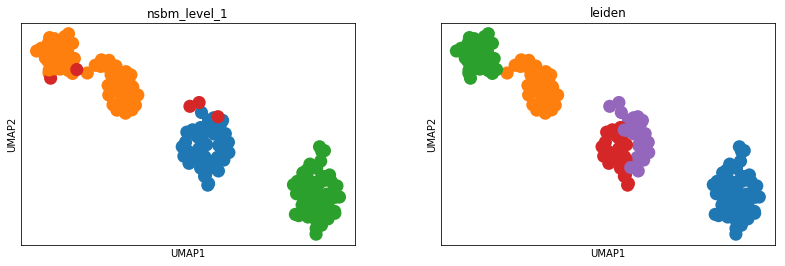

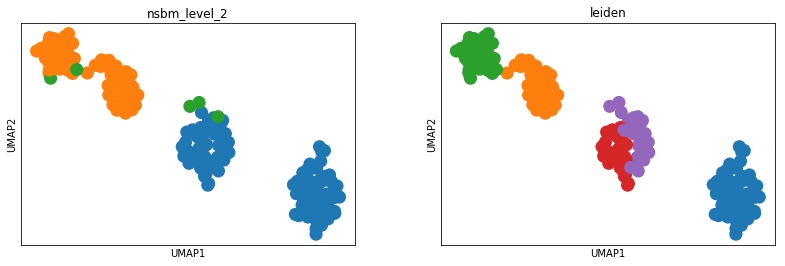

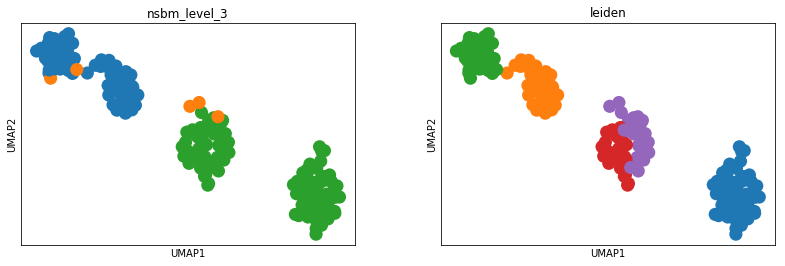

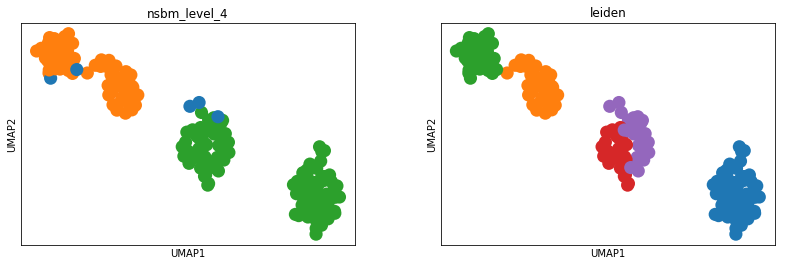

In [17]:
sc.tl.umap(unw_adata5)
sc.tl.leiden(unw_adata5)
sc.pl.umap(unw_adata5, color=["nsbm_level_1", 'leiden'], legend_loc='on_data')
sc.pl.umap(unw_adata5, color=["nsbm_level_2", 'leiden'], legend_loc='on_data')
sc.pl.umap(unw_adata5, color=["nsbm_level_3", 'leiden'], legend_loc='on_data')
sc.pl.umap(unw_adata5, color=["nsbm_level_4", 'leiden'], legend_loc='on_data')

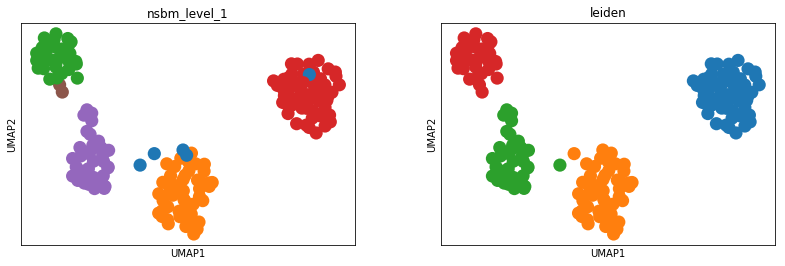

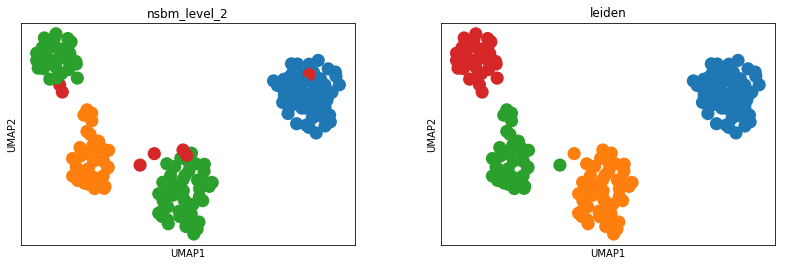

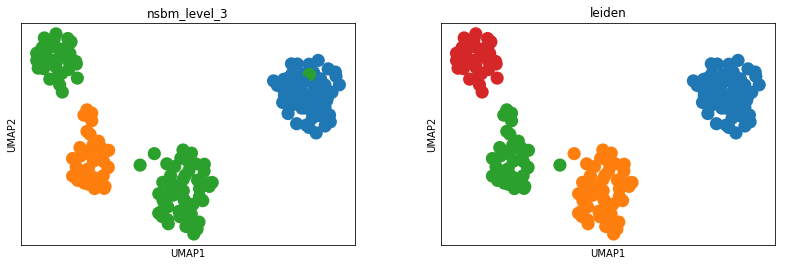

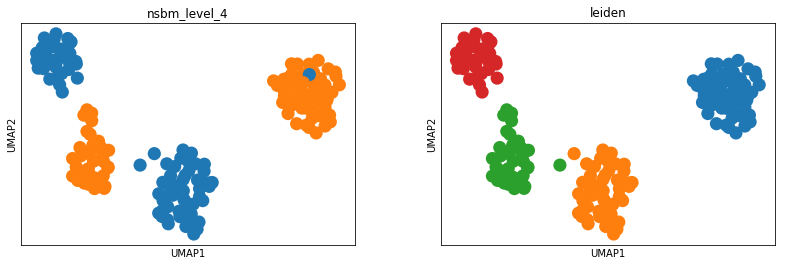

In [18]:
sc.tl.umap(unw_adata10)
sc.tl.leiden(unw_adata10)
sc.pl.umap(unw_adata10, color=["nsbm_level_1", 'leiden'], legend_loc='on_data')
sc.pl.umap(unw_adata10, color=["nsbm_level_2", 'leiden'], legend_loc='on_data')
sc.pl.umap(unw_adata10, color=["nsbm_level_3", 'leiden'], legend_loc='on_data')
sc.pl.umap(unw_adata10, color=["nsbm_level_4", 'leiden'], legend_loc='on_data')

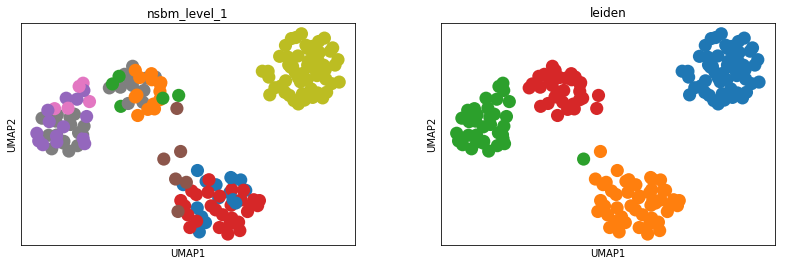

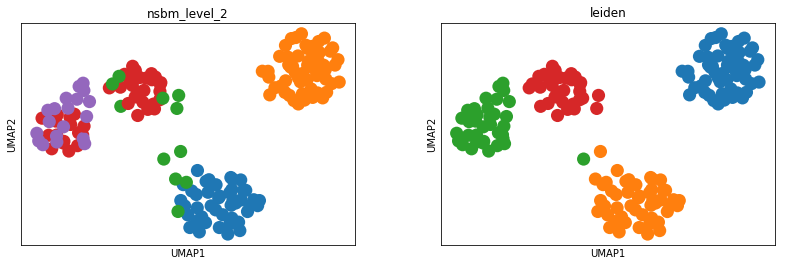

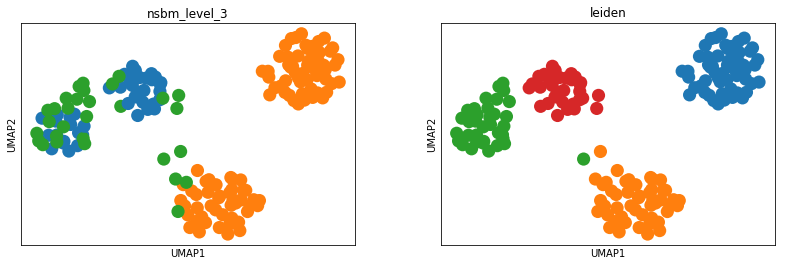

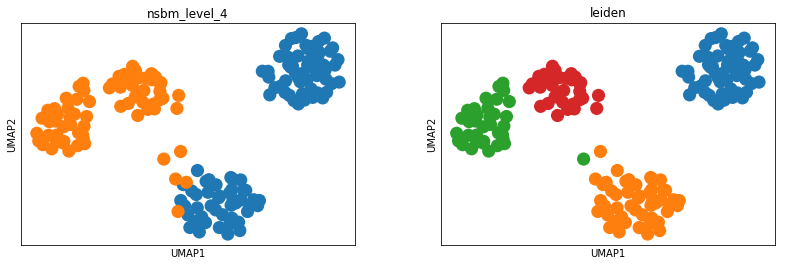

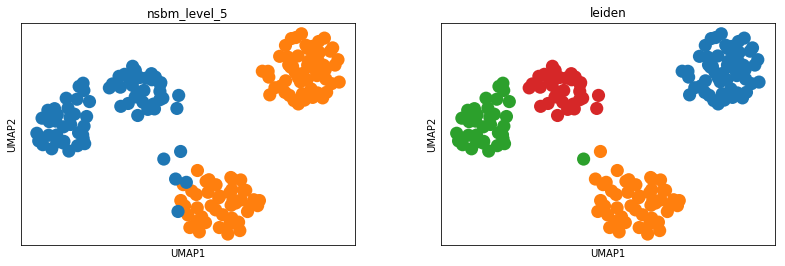

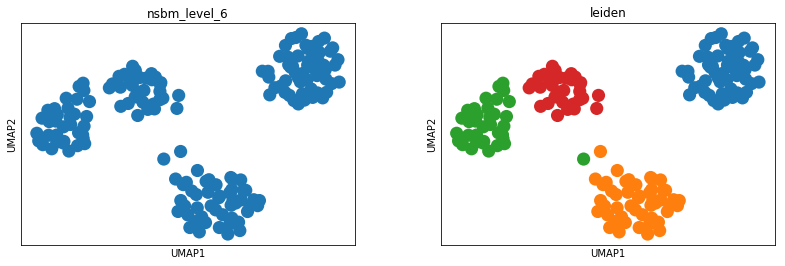

In [19]:
sc.tl.umap(unw_adata20)
sc.tl.leiden(unw_adata20)
sc.pl.umap(unw_adata20, color=["nsbm_level_1", 'leiden'], legend_loc='on_data')
sc.pl.umap(unw_adata20, color=["nsbm_level_2", 'leiden'], legend_loc='on_data')
sc.pl.umap(unw_adata20, color=["nsbm_level_3", 'leiden'], legend_loc='on_data')
sc.pl.umap(unw_adata20, color=["nsbm_level_4", 'leiden'], legend_loc='on_data')
sc.pl.umap(unw_adata20, color=["nsbm_level_5", 'leiden'], legend_loc='on_data')
sc.pl.umap(unw_adata20, color=["nsbm_level_6", 'leiden'], legend_loc='on_data')

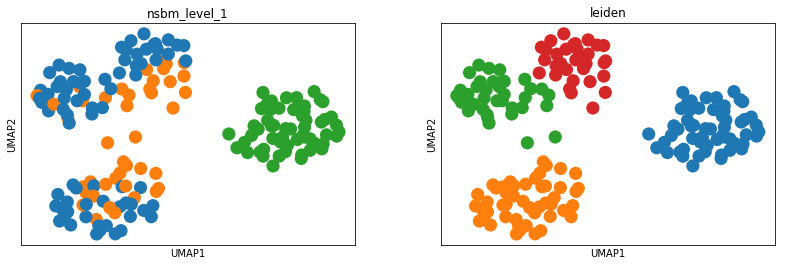

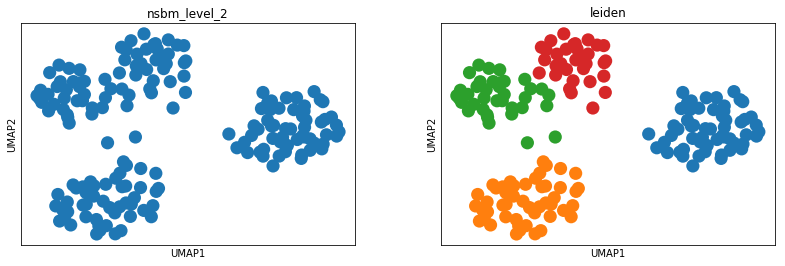

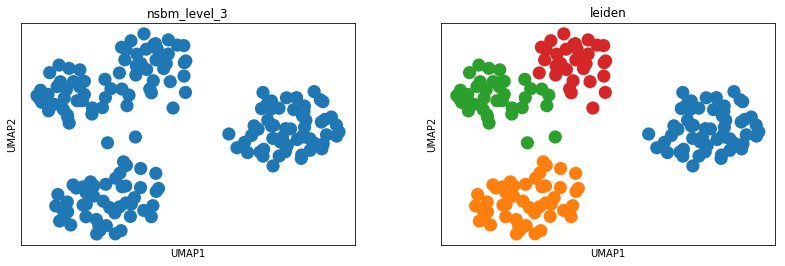

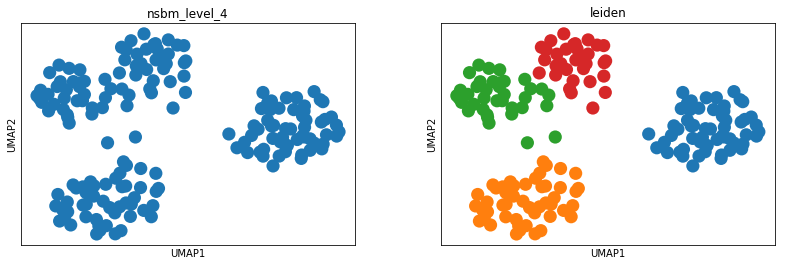

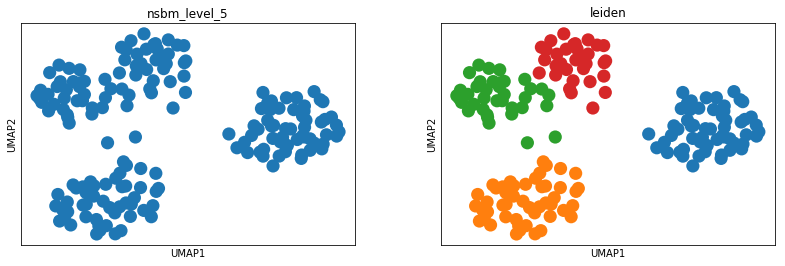

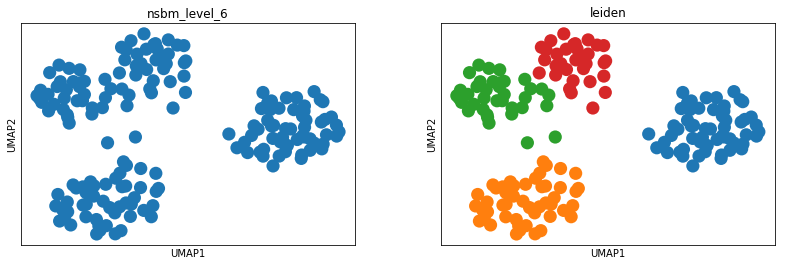

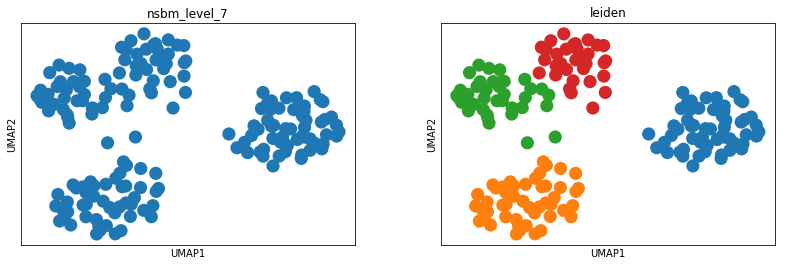

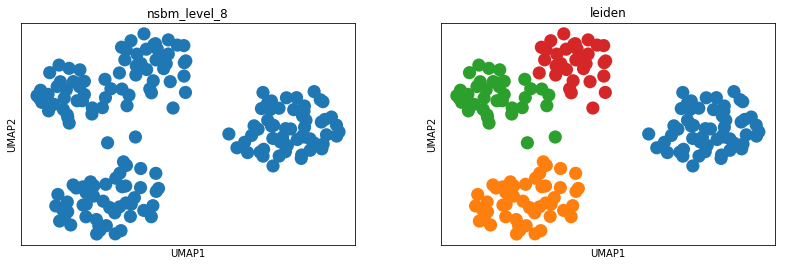

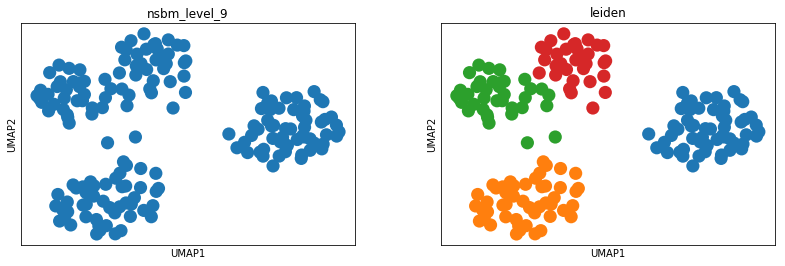

In [20]:
sc.tl.umap(unw_adata50)
sc.tl.leiden(unw_adata50)
sc.pl.umap(unw_adata50, color=["nsbm_level_1", 'leiden'], legend_loc='on_data')
sc.pl.umap(unw_adata50, color=["nsbm_level_2", 'leiden'], legend_loc='on_data')
sc.pl.umap(unw_adata50, color=["nsbm_level_3", 'leiden'], legend_loc='on_data')
sc.pl.umap(unw_adata50, color=["nsbm_level_4", 'leiden'], legend_loc='on_data')
sc.pl.umap(unw_adata50, color=["nsbm_level_5", 'leiden'], legend_loc='on_data')
sc.pl.umap(unw_adata50, color=["nsbm_level_6", 'leiden'], legend_loc='on_data')
sc.pl.umap(unw_adata50, color=["nsbm_level_7", 'leiden'], legend_loc='on_data')
sc.pl.umap(unw_adata50, color=["nsbm_level_8", 'leiden'], legend_loc='on_data')
sc.pl.umap(unw_adata50, color=["nsbm_level_9", 'leiden'], legend_loc='on_data')

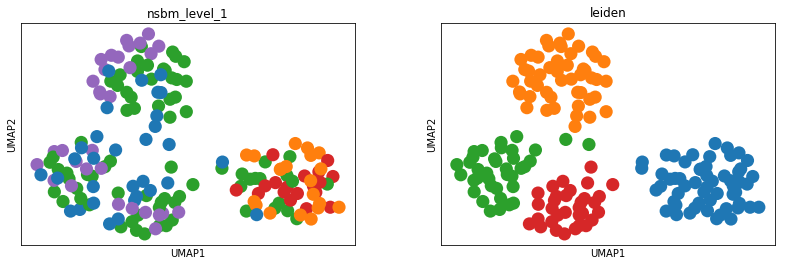

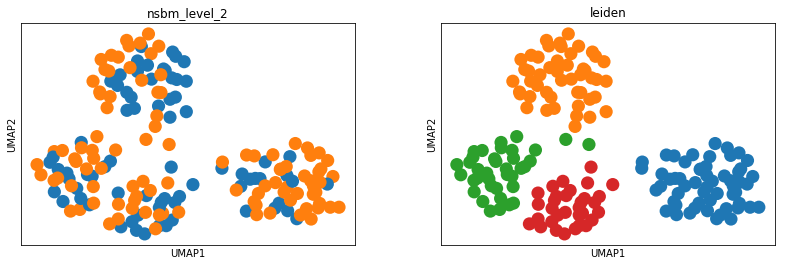

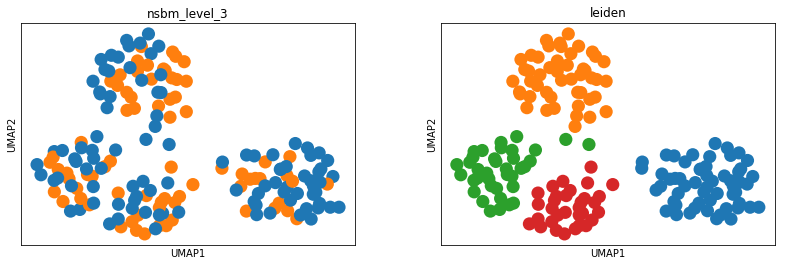

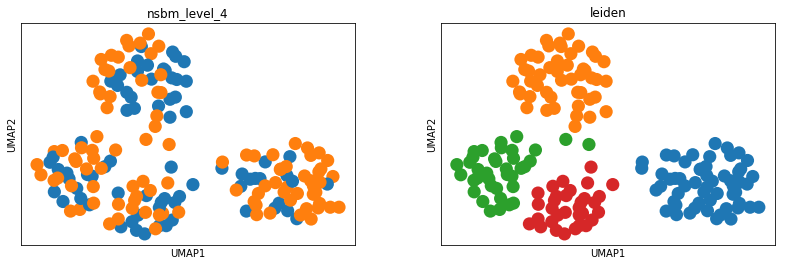

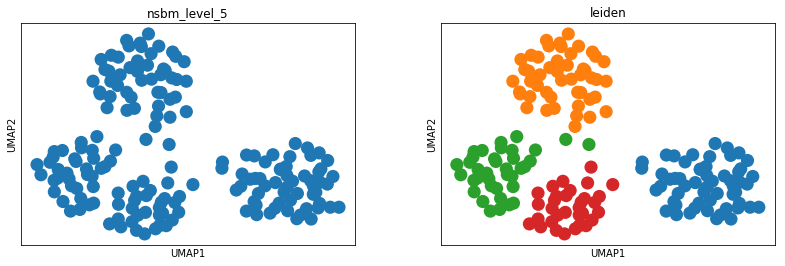

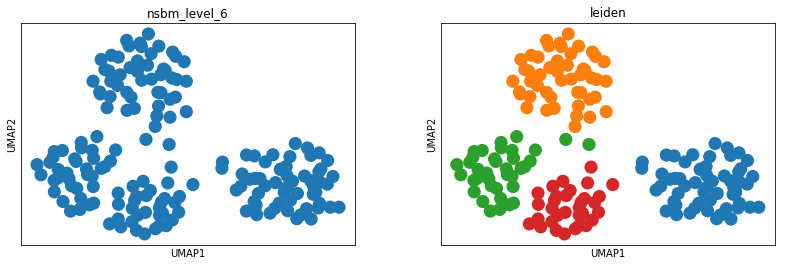

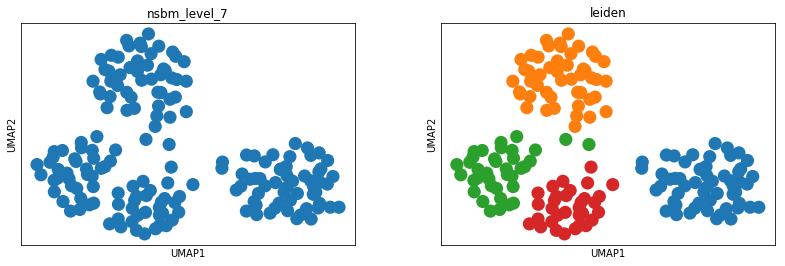

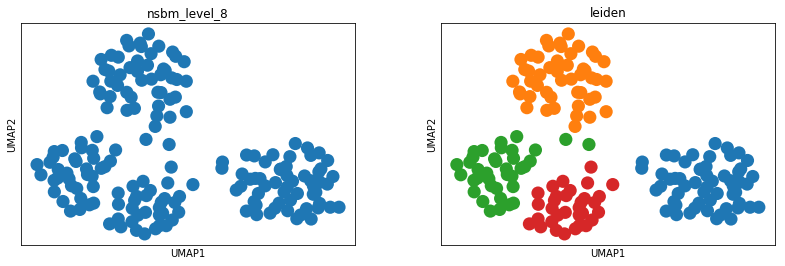

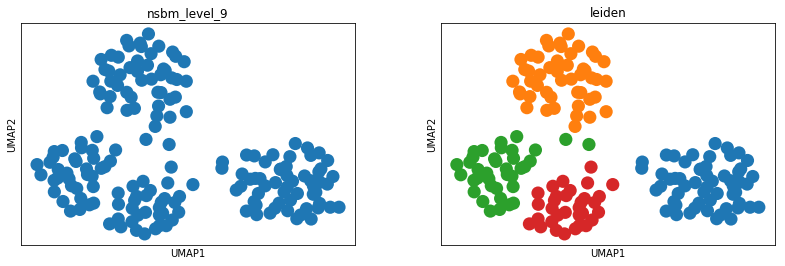

In [21]:
sc.tl.umap(unw_adata100)
sc.tl.leiden(unw_adata100)
sc.pl.umap(unw_adata100, color=["nsbm_level_1", 'leiden'], legend_loc='on_data')
sc.pl.umap(unw_adata100, color=["nsbm_level_2", 'leiden'], legend_loc='on_data')
sc.pl.umap(unw_adata100, color=["nsbm_level_3", 'leiden'], legend_loc='on_data')
sc.pl.umap(unw_adata100, color=["nsbm_level_4", 'leiden'], legend_loc='on_data')
sc.pl.umap(unw_adata100, color=["nsbm_level_5", 'leiden'], legend_loc='on_data')
sc.pl.umap(unw_adata100, color=["nsbm_level_6", 'leiden'], legend_loc='on_data')
sc.pl.umap(unw_adata100, color=["nsbm_level_7", 'leiden'], legend_loc='on_data')
sc.pl.umap(unw_adata100, color=["nsbm_level_8", 'leiden'], legend_loc='on_data')
sc.pl.umap(unw_adata100, color=["nsbm_level_9", 'leiden'], legend_loc='on_data')

### weighted

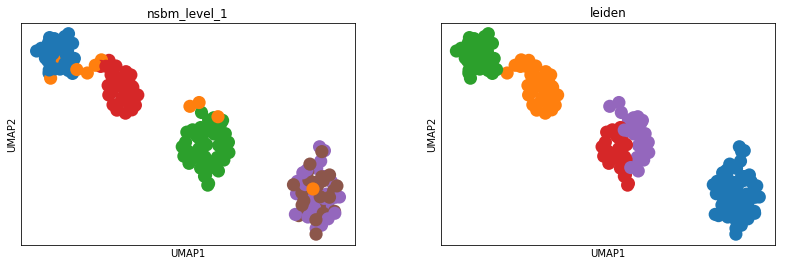

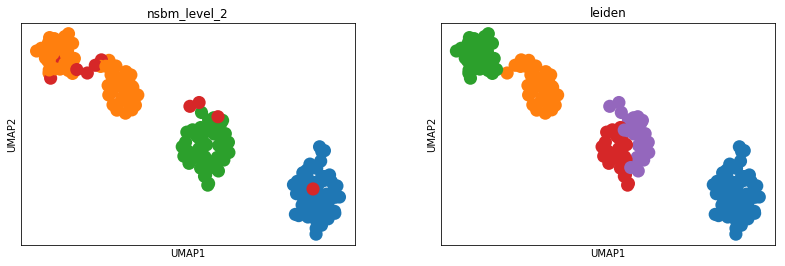

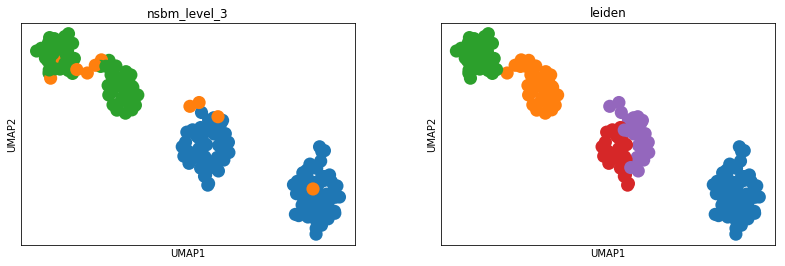

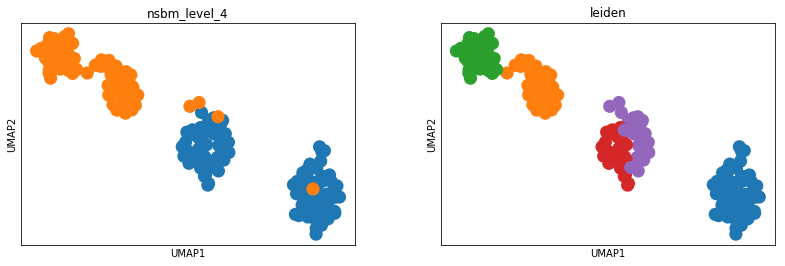

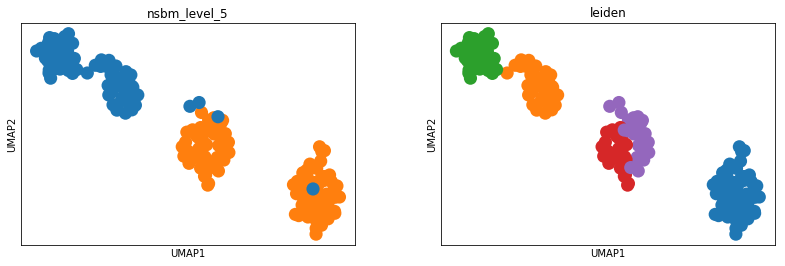

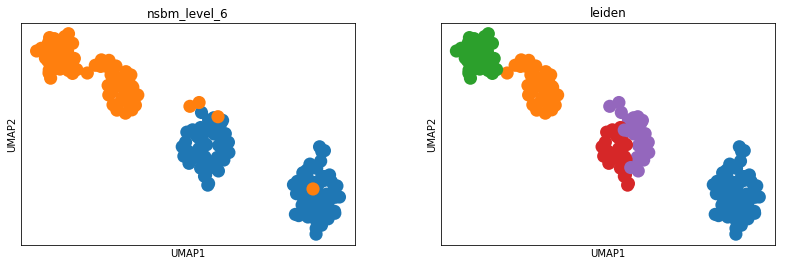

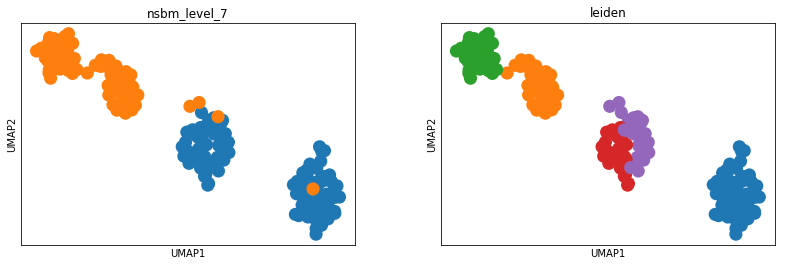

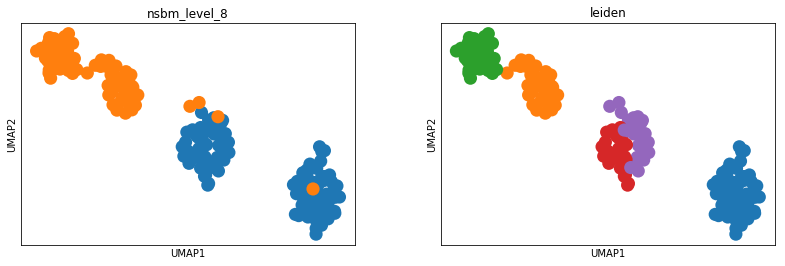

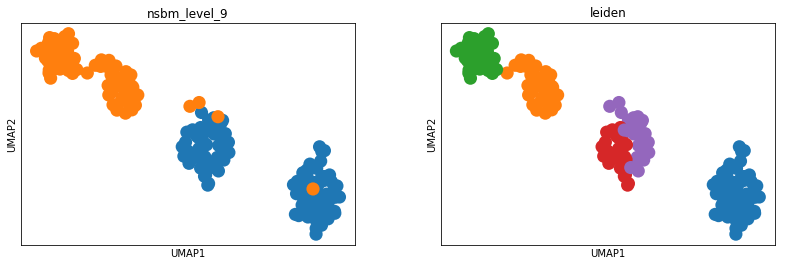

In [22]:
sc.tl.umap(w_adata5)
sc.tl.leiden(w_adata5)
sc.pl.umap(w_adata5, color=["nsbm_level_1", 'leiden'], legend_loc='on_data')
sc.pl.umap(w_adata5, color=["nsbm_level_2", 'leiden'], legend_loc='on_data')
sc.pl.umap(w_adata5, color=["nsbm_level_3", 'leiden'], legend_loc='on_data')
sc.pl.umap(w_adata5, color=["nsbm_level_4", 'leiden'], legend_loc='on_data')
sc.pl.umap(w_adata5, color=["nsbm_level_5", 'leiden'], legend_loc='on_data')
sc.pl.umap(w_adata5, color=["nsbm_level_6", 'leiden'], legend_loc='on_data')
sc.pl.umap(w_adata5, color=["nsbm_level_7", 'leiden'], legend_loc='on_data')
sc.pl.umap(w_adata5, color=["nsbm_level_8", 'leiden'], legend_loc='on_data')
sc.pl.umap(w_adata5, color=["nsbm_level_9", 'leiden'], legend_loc='on_data')

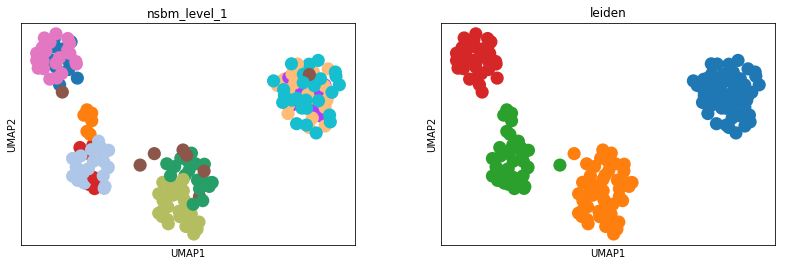

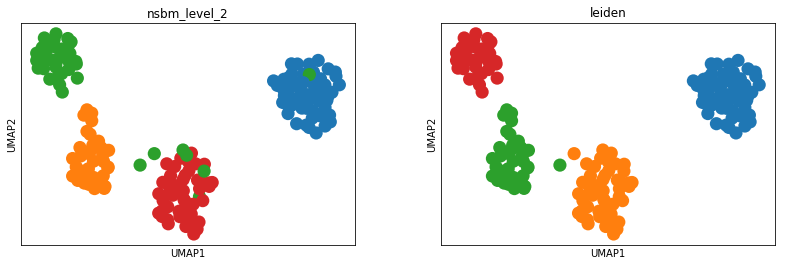

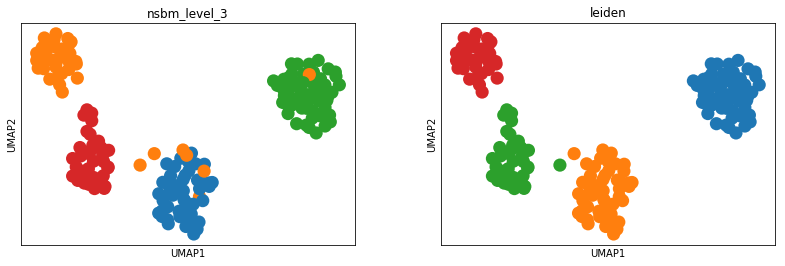

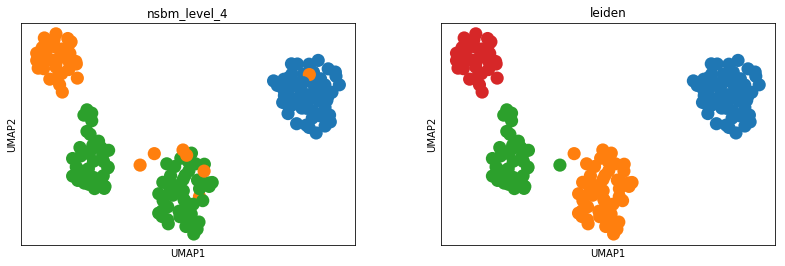

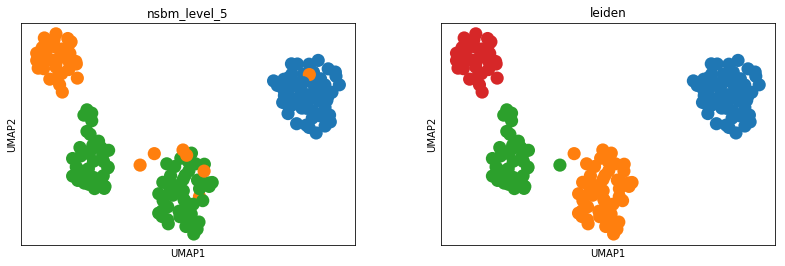

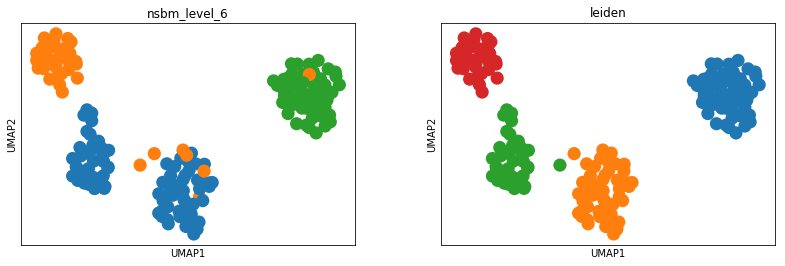

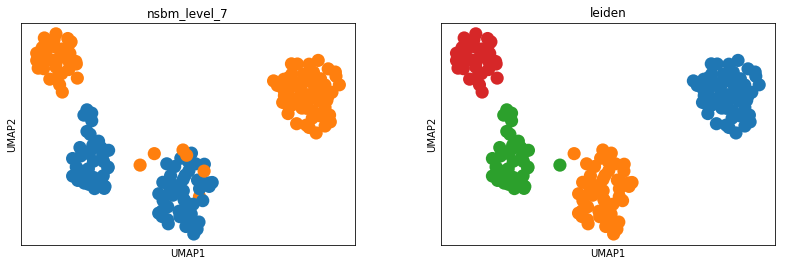

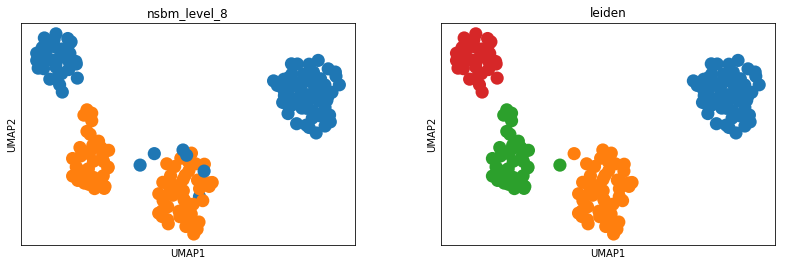

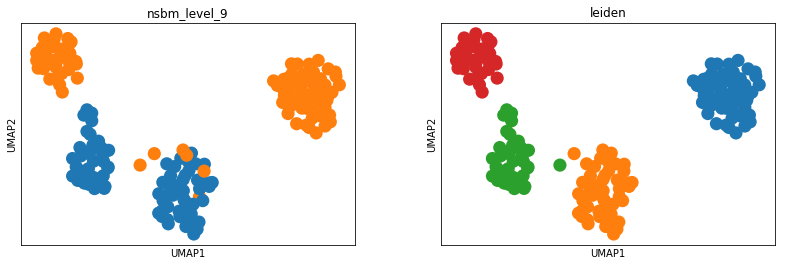

In [23]:
sc.tl.umap(w_adata10)
sc.tl.leiden(w_adata10)
sc.pl.umap(w_adata10, color=["nsbm_level_1", 'leiden'], legend_loc='on_data')
sc.pl.umap(w_adata10, color=["nsbm_level_2", 'leiden'], legend_loc='on_data')
sc.pl.umap(w_adata10, color=["nsbm_level_3", 'leiden'], legend_loc='on_data')
sc.pl.umap(w_adata10, color=["nsbm_level_4", 'leiden'], legend_loc='on_data')
sc.pl.umap(w_adata10, color=["nsbm_level_5", 'leiden'], legend_loc='on_data')
sc.pl.umap(w_adata10, color=["nsbm_level_6", 'leiden'], legend_loc='on_data')
sc.pl.umap(w_adata10, color=["nsbm_level_7", 'leiden'], legend_loc='on_data')
sc.pl.umap(w_adata10, color=["nsbm_level_8", 'leiden'], legend_loc='on_data')
sc.pl.umap(w_adata10, color=["nsbm_level_9", 'leiden'], legend_loc='on_data')

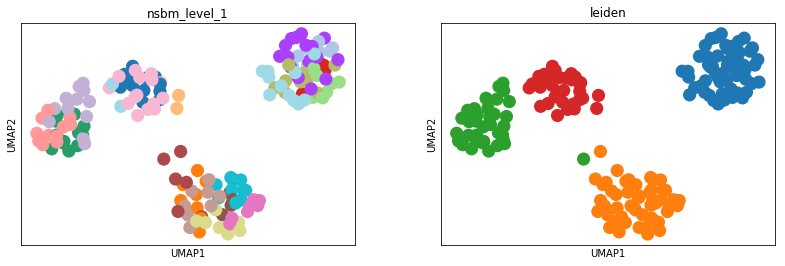

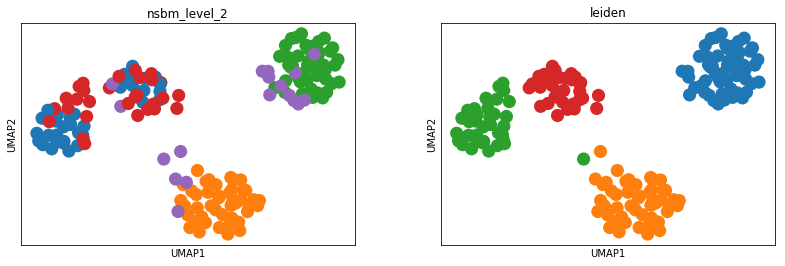

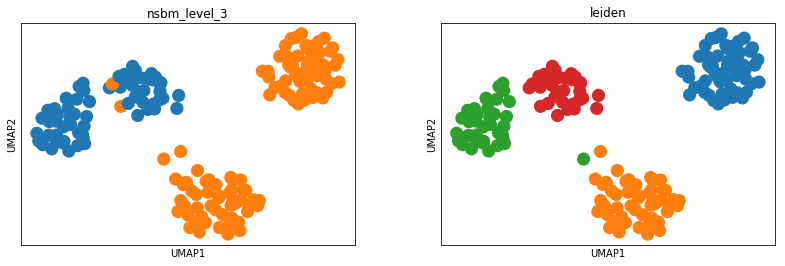

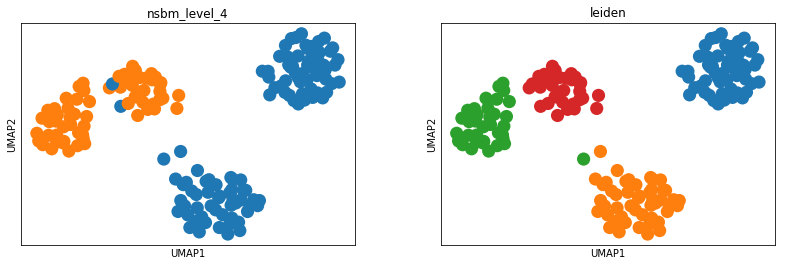

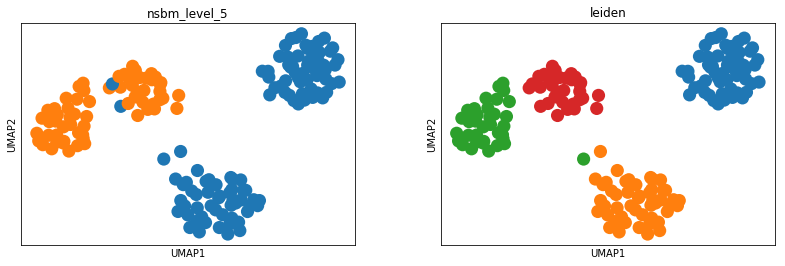

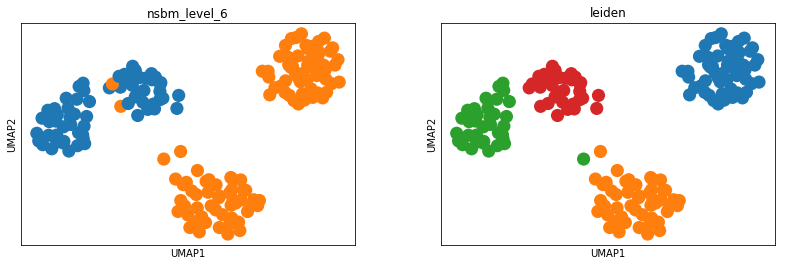

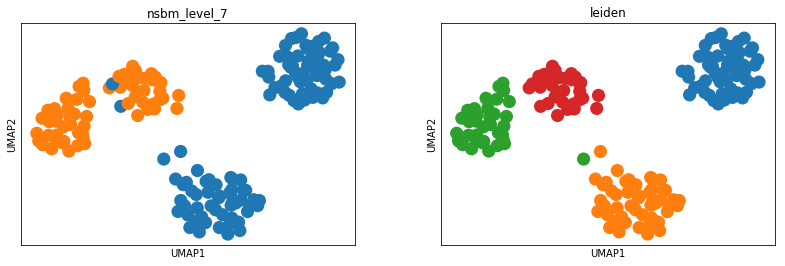

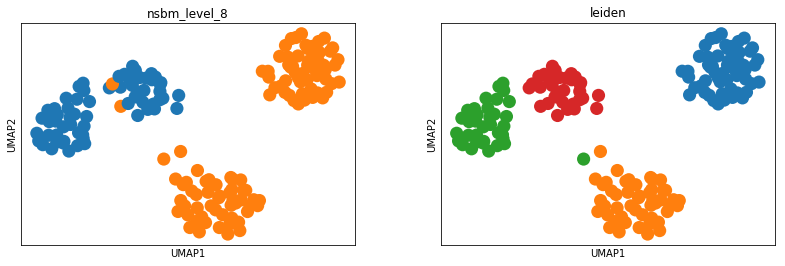

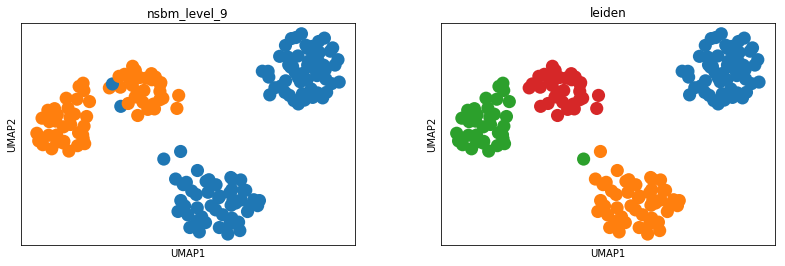

In [24]:
sc.tl.umap(w_adata20)
sc.tl.leiden(w_adata20)
sc.pl.umap(w_adata20, color=["nsbm_level_1", 'leiden'], legend_loc='on_data')
sc.pl.umap(w_adata20, color=["nsbm_level_2", 'leiden'], legend_loc='on_data')
sc.pl.umap(w_adata20, color=["nsbm_level_3", 'leiden'], legend_loc='on_data')
sc.pl.umap(w_adata20, color=["nsbm_level_4", 'leiden'], legend_loc='on_data')
sc.pl.umap(w_adata20, color=["nsbm_level_5", 'leiden'], legend_loc='on_data')
sc.pl.umap(w_adata20, color=["nsbm_level_6", 'leiden'], legend_loc='on_data')
sc.pl.umap(w_adata20, color=["nsbm_level_7", 'leiden'], legend_loc='on_data')
sc.pl.umap(w_adata20, color=["nsbm_level_8", 'leiden'], legend_loc='on_data')
sc.pl.umap(w_adata20, color=["nsbm_level_9", 'leiden'], legend_loc='on_data')

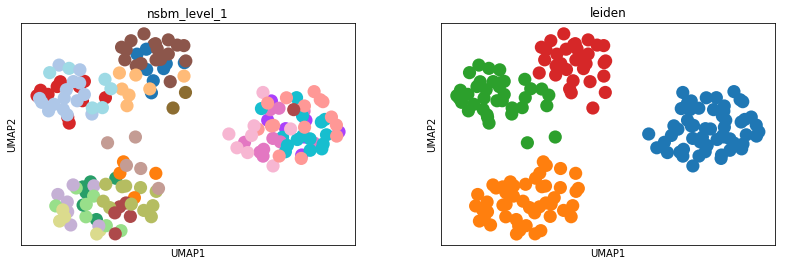

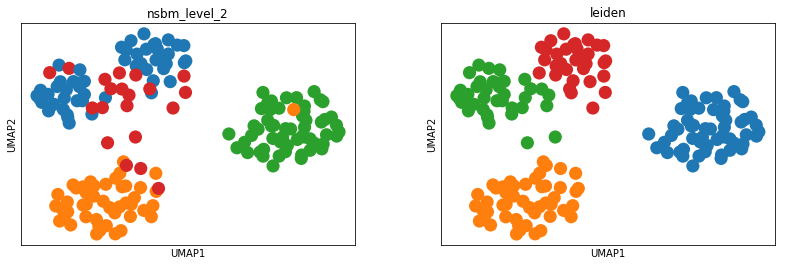

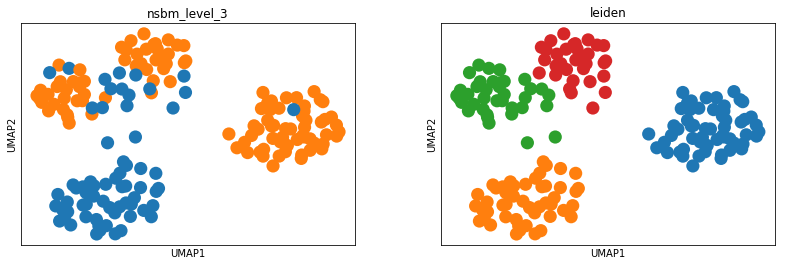

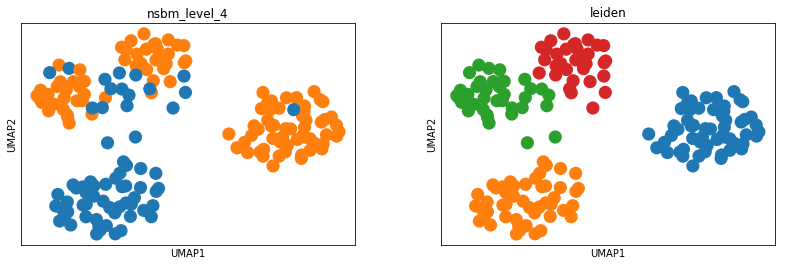

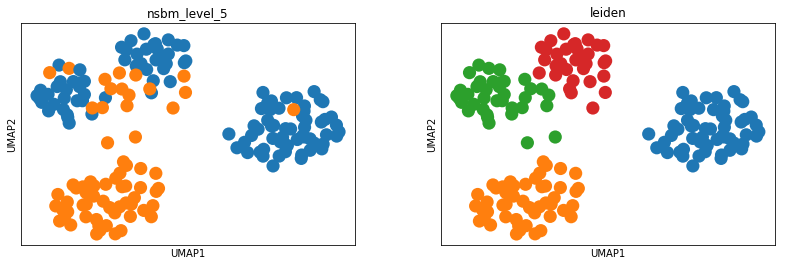

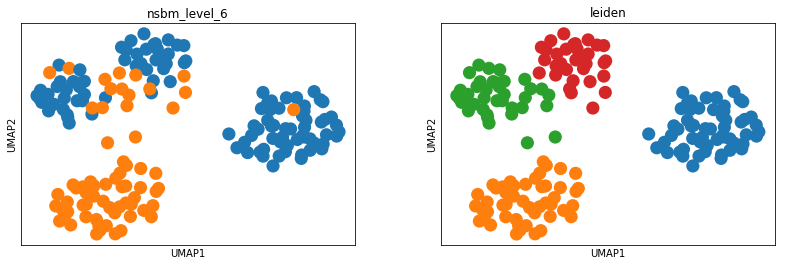

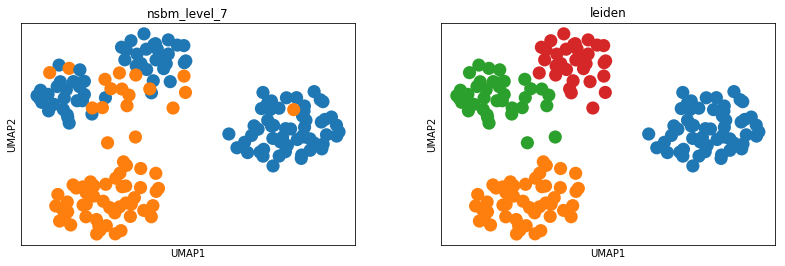

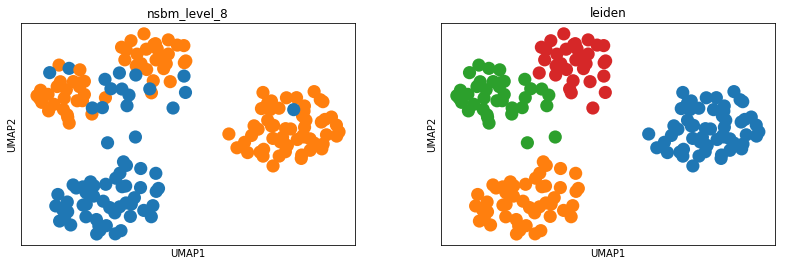

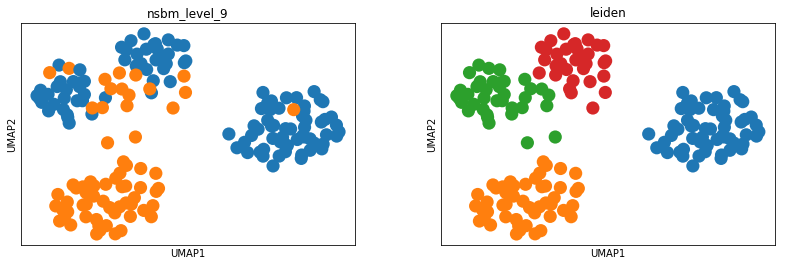

In [25]:
sc.tl.umap(w_adata50)
sc.tl.leiden(w_adata50)
sc.pl.umap(w_adata50, color=["nsbm_level_1", 'leiden'], legend_loc='on_data')
sc.pl.umap(w_adata50, color=["nsbm_level_2", 'leiden'], legend_loc='on_data')
sc.pl.umap(w_adata50, color=["nsbm_level_3", 'leiden'], legend_loc='on_data')
sc.pl.umap(w_adata50, color=["nsbm_level_4", 'leiden'], legend_loc='on_data')
sc.pl.umap(w_adata50, color=["nsbm_level_5", 'leiden'], legend_loc='on_data')
sc.pl.umap(w_adata50, color=["nsbm_level_6", 'leiden'], legend_loc='on_data')
sc.pl.umap(w_adata50, color=["nsbm_level_7", 'leiden'], legend_loc='on_data')
sc.pl.umap(w_adata50, color=["nsbm_level_8", 'leiden'], legend_loc='on_data')
sc.pl.umap(w_adata50, color=["nsbm_level_9", 'leiden'], legend_loc='on_data')

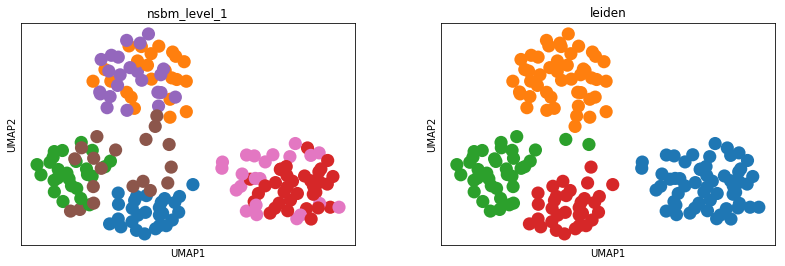

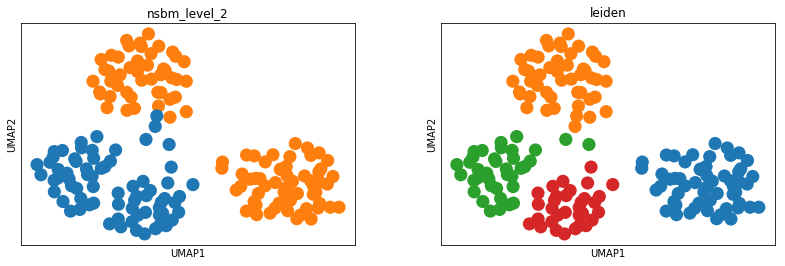

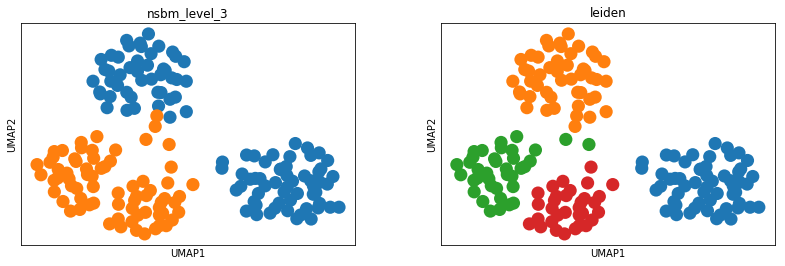

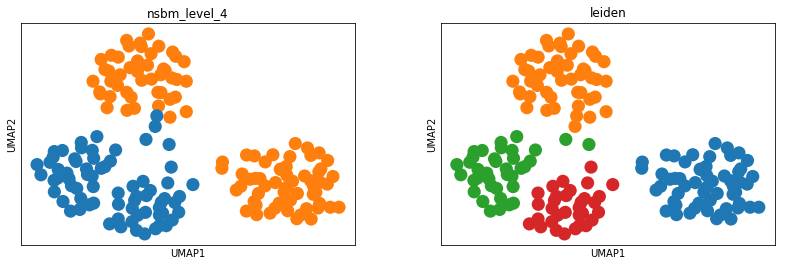

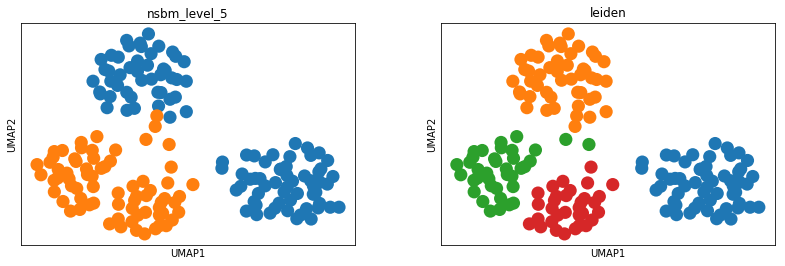

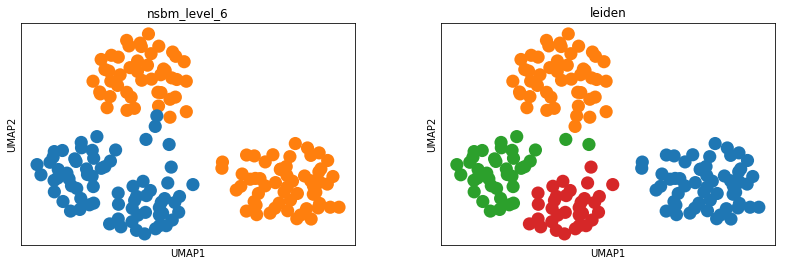

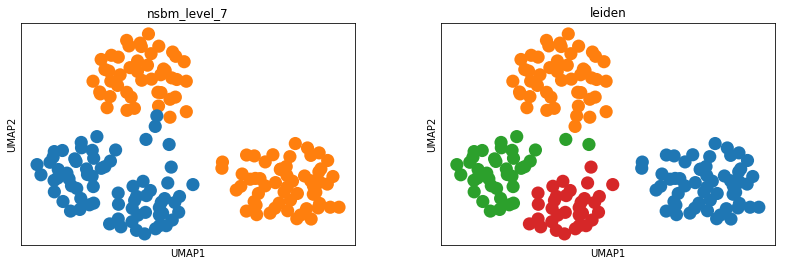

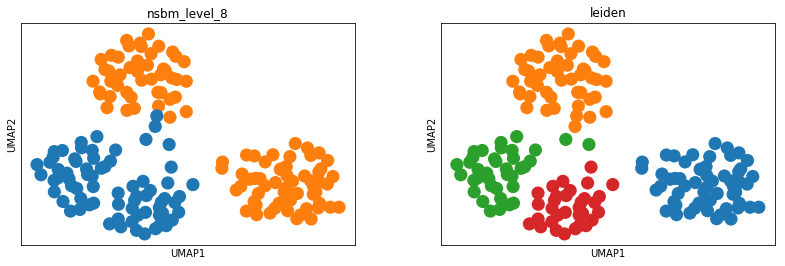

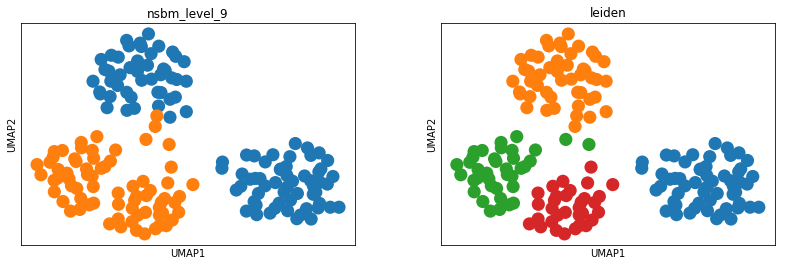

In [26]:
sc.tl.umap(w_adata100)
sc.tl.leiden(w_adata100)
sc.pl.umap(w_adata100, color=["nsbm_level_1", 'leiden'], legend_loc='on_data')
sc.pl.umap(w_adata100, color=["nsbm_level_2", 'leiden'], legend_loc='on_data')
sc.pl.umap(w_adata100, color=["nsbm_level_3", 'leiden'], legend_loc='on_data')
sc.pl.umap(w_adata100, color=["nsbm_level_4", 'leiden'], legend_loc='on_data')
sc.pl.umap(w_adata100, color=["nsbm_level_5", 'leiden'], legend_loc='on_data')
sc.pl.umap(w_adata100, color=["nsbm_level_6", 'leiden'], legend_loc='on_data')
sc.pl.umap(w_adata100, color=["nsbm_level_7", 'leiden'], legend_loc='on_data')
sc.pl.umap(w_adata100, color=["nsbm_level_8", 'leiden'], legend_loc='on_data')
sc.pl.umap(w_adata100, color=["nsbm_level_9", 'leiden'], legend_loc='on_data')

# 3) MI comparison
### 3.1) nsbm unweighted vs leiden unweighted

### 3.2) nsbm weighted vs leiden weighted

### 3.3) nsbm weighted vs leiden unweighted

### 3.4) nsbm unweighted vs leiden weighted